# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель исследования**

Определить, где бурить новую скважину

---

**Задачи исследования**

Построить модель для определения региона, где добыча принесёт наибольшую прибыль

---

**Исходные данные**  

Данные геологоразведки трёх регионов находятся в файлах: 
    
- `/datasets/geo_data_0.csv`

- `/datasets/geo_data_1.csv`
    
- `/datasets/geo_data_2.csv`

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек 
- **product** — объём запасов в скважине (тыс. баррелей).

In [1]:
!pip install phik -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
#Объявим константы

RANDOM_STATE = 42

## Загрузка и подготовка данных

### Загрузка данных

In [4]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Предобработка данных

In [5]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('размер датафрейма', name, ':', df.shape)
    print('_'*125)
    
    print('Первые 5 строк датафрейма', name)
    display(df.head())
    print('_'*125)
    
    print('Последнии 5 строк датафрейма', name)
    display(df.tail())
    print('_'*125)
    
    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)
        
    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)
    
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())
    
    print('*'*125)

In [6]:
#Вызовем функцию для датасета 'geo_data_0'
describe_df(geo_data_0, 'geo_data_0')

размер датафрейма geo_data_0 : (100000, 5)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма geo_data_0


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


_____________________________________________________________________________________________________________________________
Информация о датафрейме geo_data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
_____________________________________________________________________________________________________________________________
Описание датафрейма geo_data_0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте geo_data_0 : 0
Количество пропусков в датафрейте geo_data_0 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
*****************************************************************************************************************************


In [7]:
#Вызовем функцию для датасета 'geo_data_1'
describe_df(geo_data_1, 'geo_data_1')

размер датафрейма geo_data_1 : (100000, 5)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма geo_data_1


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


_____________________________________________________________________________________________________________________________
Информация о датафрейме geo_data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
_____________________________________________________________________________________________________________________________
Описание датафрейма geo_data_1


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте geo_data_1 : 0
Количество пропусков в датафрейте geo_data_1 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
*****************************************************************************************************************************


In [8]:
#Вызовем функцию для датасета 'geo_data_2'
describe_df(geo_data_2, 'geo_data_2')

размер датафрейма geo_data_2 : (100000, 5)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма geo_data_2


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


_____________________________________________________________________________________________________________________________
Информация о датафрейме geo_data_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
_____________________________________________________________________________________________________________________________
Описание датафрейма geo_data_2


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте geo_data_2 : 0
Количество пропусков в датафрейте geo_data_2 : 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
*****************************************************************************************************************************


Столбец `id` не важен для дальнейшего анализа, сделаем его индексом

In [9]:
geo_data_0 = geo_data_0.set_index('id') 
geo_data_1 = geo_data_1.set_index('id') 
geo_data_2 = geo_data_2.set_index('id') 

In [10]:
# Убедимся, что после удаления Id не появились дубликаты
print('Количество явных дубликатов в датафрейте geo_data_0:', geo_data_0.duplicated().sum())
print('Количество явных дубликатов в датафрейте geo_data_1:', geo_data_1.duplicated().sum())
print('Количество явных дубликатов в датафрейте geo_data_2:', geo_data_2.duplicated().sum())

Количество явных дубликатов в датафрейте geo_data_0: 0
Количество явных дубликатов в датафрейте geo_data_1: 0
Количество явных дубликатов в датафрейте geo_data_2: 0


#### Вывод по предобработке данных

Данные в таблицах соответствуют описанию. В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов

На этапе предобработке данных проверили, что в данных:

- нет дубликатов
- нет пропусков
- типы столбцов указаны верно
- Название столбцов корректны

Столбец `id` сделали индексом


### Исследовательский анализ данных

In [11]:
# В целях оптимизации, напишем функцию для получения общей информации о столбце
def describe_column(df, column):
    print('Количество строк',  ':', df[column].shape[0])
    print('_'*125)
        
    print('Описание данных')
    display(df[column].describe().T)
    print('_'*125)
    
    print('Количество уникальных значений:', df[column].unique().shape[0])
    print('Количество пропусков в датафрейте', df[column].isna().sum())
    print('_'*125)
    
    if type(df[column].loc[1]) == str:
        print('Уникальные значения')
        print(df[column].value_counts())
    
    print('*'*125)

In [12]:
# Напишем функцию построения гистограммы и диграммы размаха для количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df[column].plot(ax=ax[0], kind='hist')
     
    sns.boxplot(df[column], ax=ax[1])
    
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column)
    
    ax[1].set_title('Диграмма размаха')
    ax[1].set_xlabel(column)
    
    plt.show()

#### geo_data_0

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


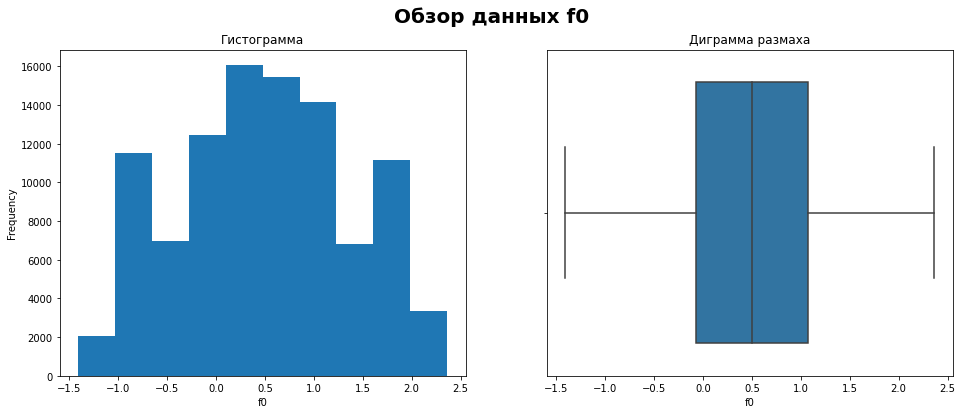

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


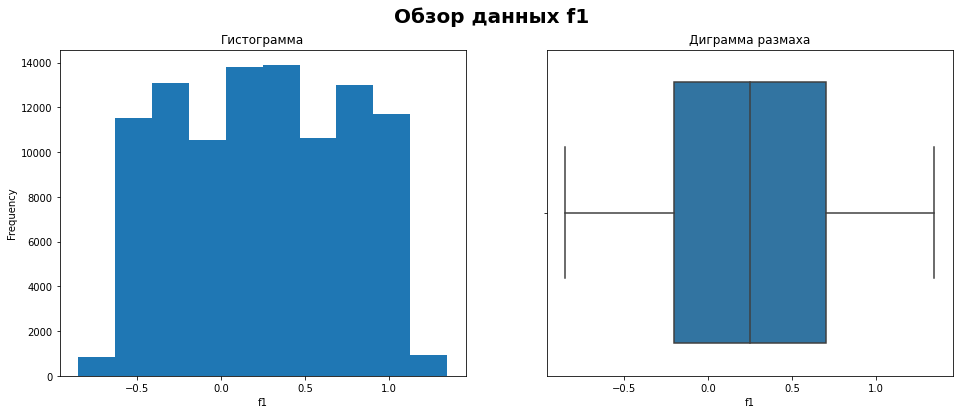

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


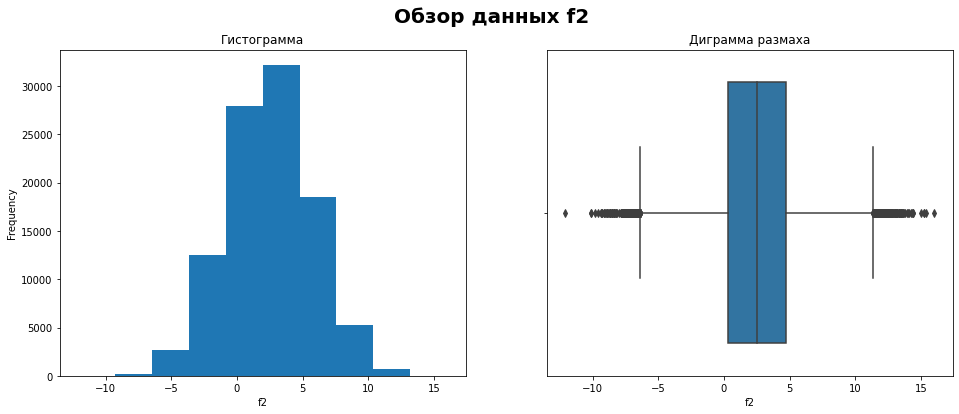

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


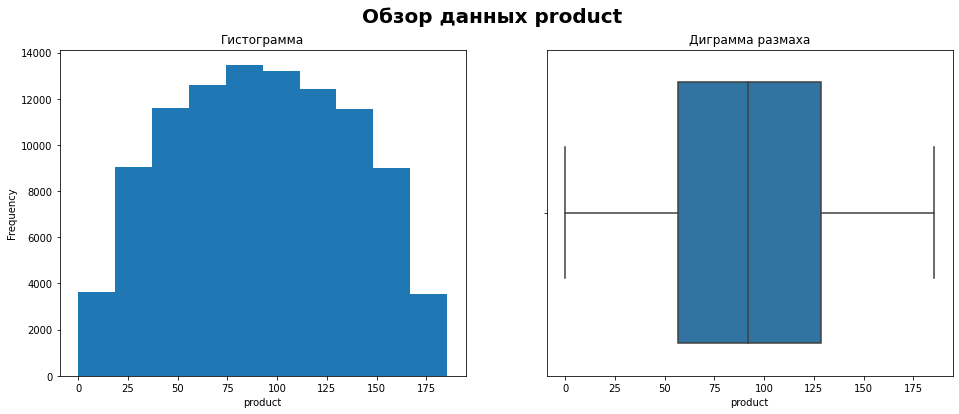

In [13]:
columns = ['f0', 'f1', 'f2', 'product']

for column in columns:
    #Построим графики для датасета geo_data_0
    hix_box_plot(geo_data_0, column)

В столбце `f2` есть выбросы, поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, считаю правильным их удалить. 

Для отсеивания выбросов будем использовать метод Межквартильного размаха

In [14]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_0['f2'].quantile(0.25)
Q3 = geo_data_0['f2'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -6.35
Верхняя граница 11.36


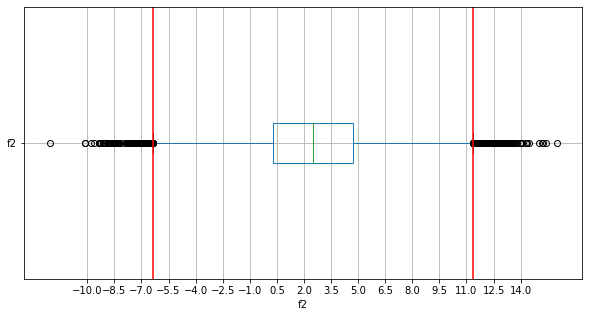

In [15]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_0.boxplot('f2', vert=False)
plt.xticks(np.arange(-10, 15, 1.5))
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')
plt.xlabel('f2')

plt.show()


В нашем случае распределение данных близко к нормальному, поэтому для отсеивания выбросов можно использовать метод Межквартильного размаха

In [16]:
print('Доля выбросов:', geo_data_0[(geo_data_0['f2'] > upper) | (geo_data_0['f2'] < lower)].shape[0]/\
     geo_data_0.shape[0])

Доля выбросов: 0.00506


In [17]:
#Удалим выбросы
geo_data_0 = geo_data_0[(geo_data_0['f2'] < upper) & (geo_data_0['f2'] > lower)]
geo_data_0.shape

(99494, 4)

**Вывод** В дфтафрейме geo_data_0 в столбце 'f2' удалили выбросы методом Межквартильного размаха

#### geo_data_1

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


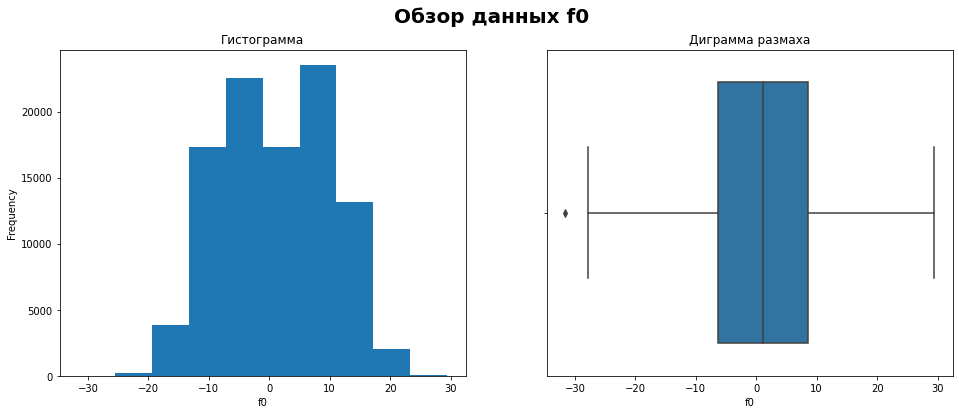

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


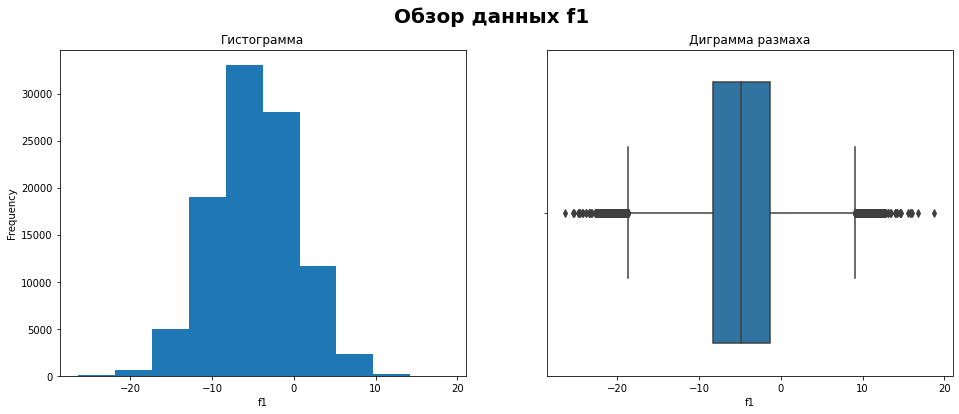

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


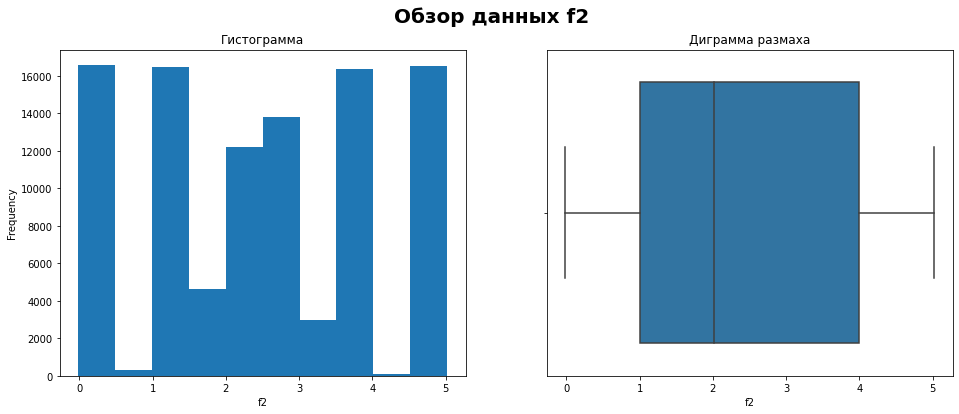

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


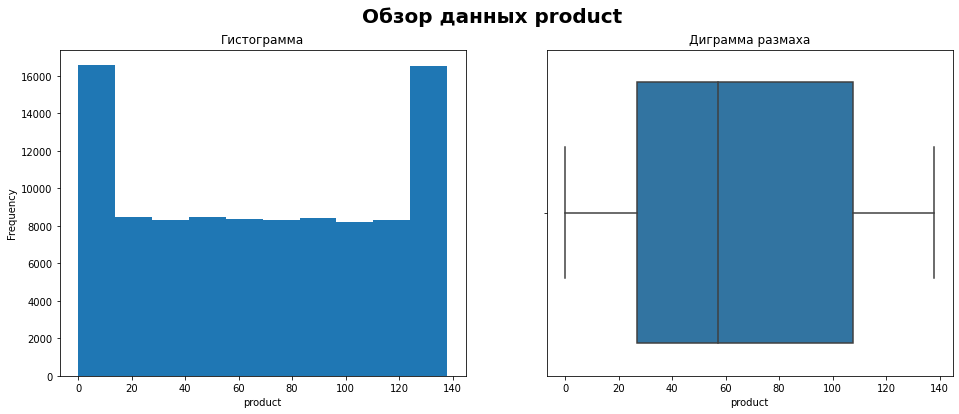

In [18]:
for column in columns:
    #Построим графики для датасета geo_data_1
    hix_box_plot(geo_data_1, column)

В столбцах `f0`, `f1` есть выбросы, поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, считаю правильным их удалить. 

Для отсеивания выбросов будем использовать метод Межквартильного размаха

**Удаление выбрасов в солбце f0:**

In [19]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_1['f0'].quantile(0.25)
Q3 = geo_data_1['f0'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -28.68
Верхняя граница 31.0


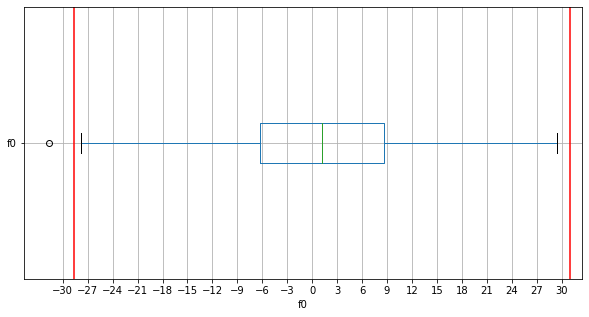

In [20]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_1.boxplot('f0', vert=False)
plt.xticks(np.arange(-30, 31, 3))
plt.xlabel('f0')
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')

plt.show()

Хотя распределение данных близко к нормальнону, границы выбросов определенные методом Межквартильного размаха и на графике boxplot хоть и не сильно, но уже отличаются. В данном случае считаю, что отсеять выбросы можно методом Межквартильного размаха

In [21]:
print('Доля выбросов:', geo_data_1[(geo_data_1['f0'] > upper) | (geo_data_1['f0'] < lower)].shape[0]/\
     geo_data_1.shape[0])

Доля выбросов: 1e-05


In [22]:
#Удалим выбросы
geo_data_1 = geo_data_1[(geo_data_1['f0'] < upper) & (geo_data_1['f0'] > lower)]
geo_data_1.shape

(99999, 4)

**Удаление выбрасов в солбце f1:**

In [23]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_1['f1'].quantile(0.25)
Q3 = geo_data_1['f1'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -18.67
Верхняя граница 9.07


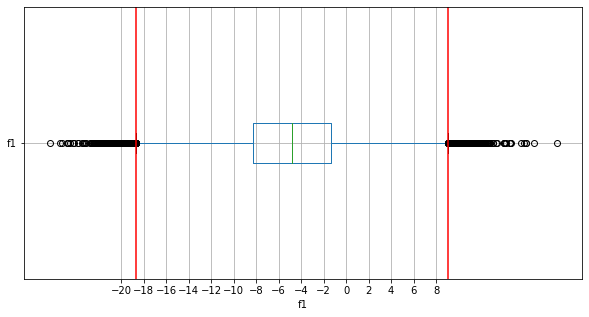

In [24]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_1.boxplot('f1', vert=False)
plt.xticks(np.arange(-20, 10, 2))
plt.xlabel('f1')
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')

plt.show()

В данном случае распределение данных близко к нормальному, поэтому для отсеивания выбросов можно использовать метод Межквартильного размаха

In [25]:
print('Доля выбросов:', geo_data_1[(geo_data_1['f1'] > upper) | (geo_data_1['f1'] < lower)].shape[0]/\
     geo_data_1.shape[0])

Доля выбросов: 0.006360063600636006


In [26]:
#Удалим выбросы
geo_data_1 = geo_data_1[(geo_data_1['f1'] < upper) & (geo_data_1['f1'] > lower)]
geo_data_1.shape

(99363, 4)

#### geo_data_2

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


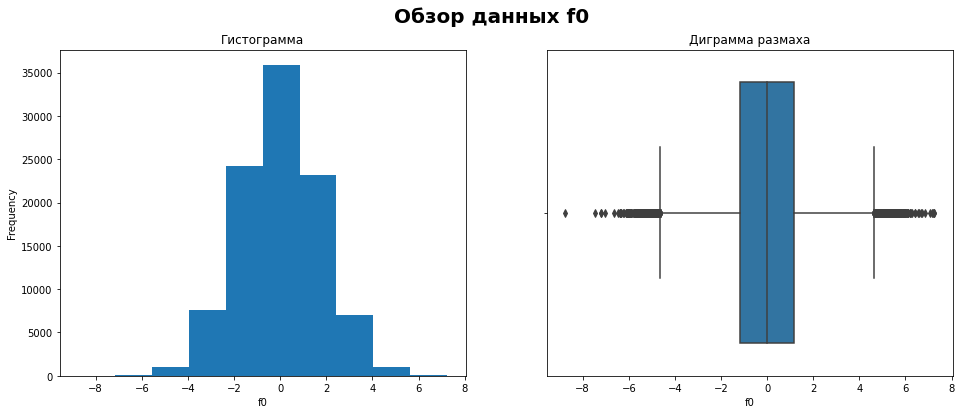

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


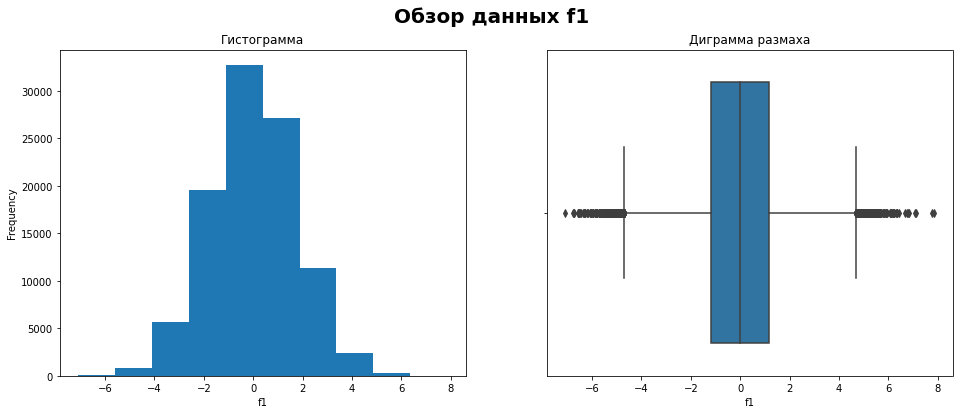

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


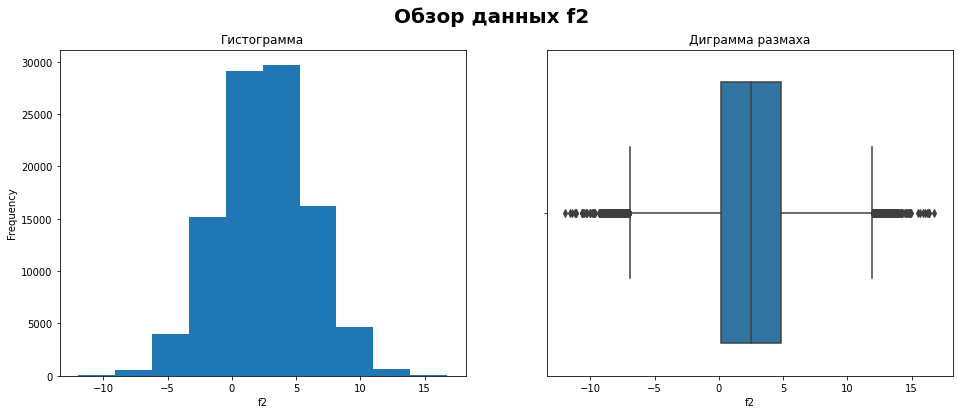

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


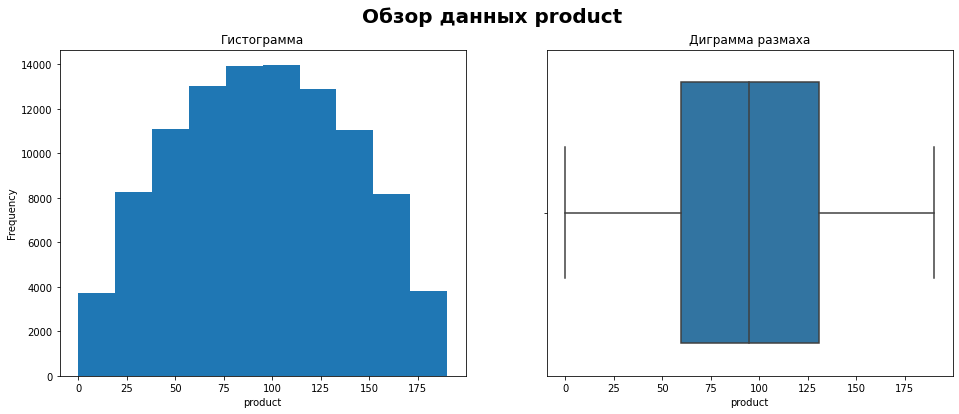

In [27]:
for column in columns:
    #Построим графики для датасета geo_data_2
    hix_box_plot(geo_data_2, column)

В столбцах `f0`, `f1`, `f2` есть выбросы, поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, считаю правильным их удалить. 

Для отсеивания выбросов будем использовать метод Межквартильного размаха

**Удаление выбрасов в солбце f0:**

In [28]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_2['f0'].quantile(0.25)
Q3 = geo_data_2['f0'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -4.64
Верхняя граница 4.64


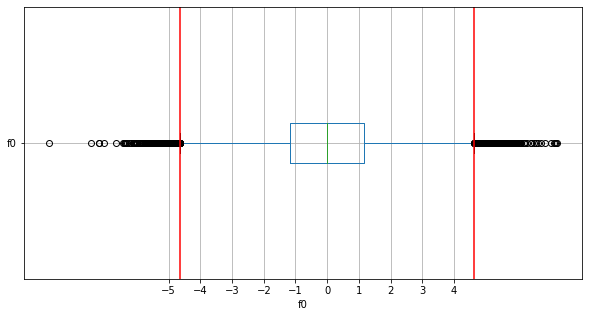

In [29]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_2.boxplot('f0', vert=False)
plt.xticks(np.arange(-5, 5, 1))
plt.xlabel('f0')
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')

plt.show()

В данном случае распределение данных близко к нормальному, поэтому для отсеивания выбросов можно использовать метод Межквартильного размаха

In [30]:
print('Доля выбросов:', geo_data_2[(geo_data_2['f0'] > upper) | (geo_data_2['f0'] < lower)].shape[0]/\
     geo_data_2.shape[0])

Доля выбросов: 0.00733


In [31]:
#Удалим выбросы
geo_data_2 = geo_data_2[(geo_data_2['f0'] < upper) & (geo_data_2['f0'] > lower)]
geo_data_2.shape

(99267, 4)

**Удаление выбрасов в солбце f1:**

In [32]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_2['f1'].quantile(0.25)
Q3 = geo_data_2['f1'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -4.68
Верхняя граница 4.67


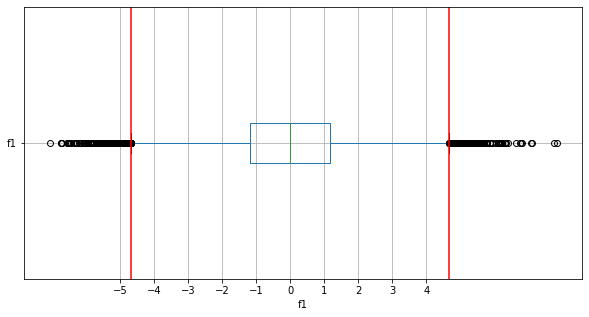

In [33]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_2.boxplot('f1', vert=False)
plt.xticks(np.arange(-5, 5, 1))
plt.xlabel('f1')
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')

plt.show()

В данном случае распределение данных близко к нормальному, поэтому для отсеивания выбросов можно использовать метод Межквартильного размаха

In [34]:
print('Доля выбросов:', geo_data_2[(geo_data_2['f1'] > upper) | (geo_data_2['f1'] < lower)].shape[0]/\
     geo_data_2.shape[0])

Доля выбросов: 0.006870359736871267


In [35]:
#Удалим выбросы
geo_data_2 = geo_data_2[(geo_data_2['f1'] < upper) & (geo_data_2['f1'] > lower)]
geo_data_2.shape

(98585, 4)

**Удаление выбрасов в солбце f2:**

In [36]:
#Найдем верхную и нижнюю границы
Q1 = geo_data_2['f2'].quantile(0.25)
Q3 = geo_data_2['f2'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Нижняя граница', lower.round(2))
print('Верхняя граница', upper.round(2))

Нижняя граница -6.96
Верхняя граница 11.95


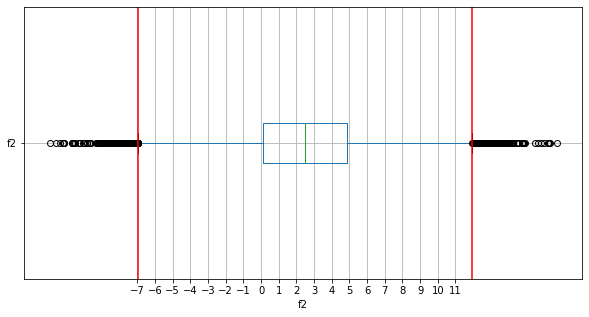

In [37]:
#Изобразим на графике боксплот где проходят границы Межквартильного размаха
fig, ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10, 5)

geo_data_2.boxplot('f2', vert=False)
plt.xticks(np.arange(-7, 12, 1))
plt.xlabel('f2')
plt.axvline(x = lower, color = 'r')
plt.axvline(x = upper, color = 'r')

plt.show()

В данном случае распределение данных близко к нормальному, поэтому для отсеивания выбросов можно использовать метод Межквартильного размаха

In [38]:
print('Доля выбросов:', geo_data_2[(geo_data_2['f2'] > upper) | (geo_data_2['f2'] < lower)].shape[0]/\
     geo_data_2.shape[0])

Доля выбросов: 0.0059035350205406505


In [39]:
#Удалим выбросы
geo_data_2 = geo_data_2[(geo_data_2['f2'] < upper) & (geo_data_2['f2'] > lower)]
geo_data_2.shape

(98003, 4)

In [40]:
# Посмотрим сколько данных удалили
print('В фрейме geo_data_0 удалили:', round(1 - geo_data_0.shape[0] / 100000, 2) * 100, '% данных')
print('В фрейме geo_data_1 удалили:', round(1 - geo_data_1.shape[0] / 100000, 2) * 100, '% данных')
print('В фрейме geo_data_2 удалили:', round(1 - geo_data_2.shape[0] / 100000, 2) * 100, '% данных')

В фрейме geo_data_0 удалили: 1.0 % данных
В фрейме geo_data_1 удалили: 1.0 % данных
В фрейме geo_data_2 удалили: 2.0 % данных


#### Вывод по исследовательскому анализу

На этапе исследовательского анализа данных были обнаружены выбросы. Поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, Было принято решения об удалении выбросов.

Для отсеивания выбросов использовали метод Межквартильного размаха

###  Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

#### geo_data_0

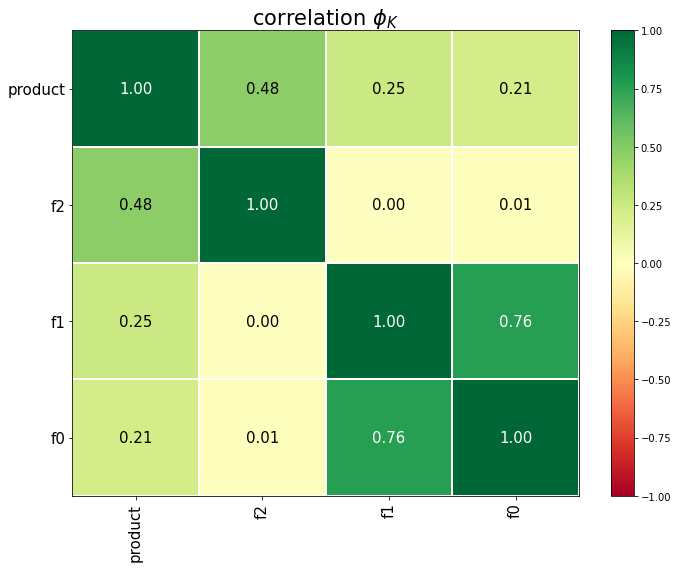

In [41]:
# вычисление коэффициентов корреляции phi для датафрейма geo_data_0
phik_overview = geo_data_0.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

Из анализа матрицы корреляции датасета geo_data_0 видно, что мультиколлинеарности нет.

При этом целевой признак product слабо коррелирует (0,48) с признаком f2.

Также прослеживается сильная корреляция между признаками f1 и f0.

Остальные признаки коррелируют между собой слабо.

#### geo_data_1

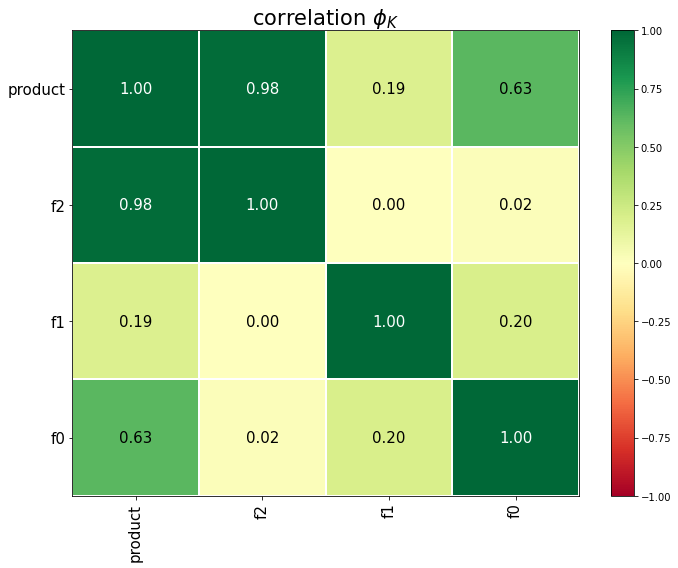

In [42]:
# вычисление коэффициентов корреляции phi для датафрейма geo_data_1
phik_overview = geo_data_1.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

Из анализа матрицы корреляции датасета geo_data_1 видно, что мультиколлинеарность прослеживается между целевым признаком (product) и признаком f2 (коэффициент корреляции 0.98). Избавляться от нее на данном этапе не будем, так как это корреляция с целевым признаком.

Также прослеживается средняя корреляция между целевым признаком (product) и признаком f0 (коэффициент корреляции 0.63)

Остальные признаки коррелируют между собой слабо.

#### geo_data_2

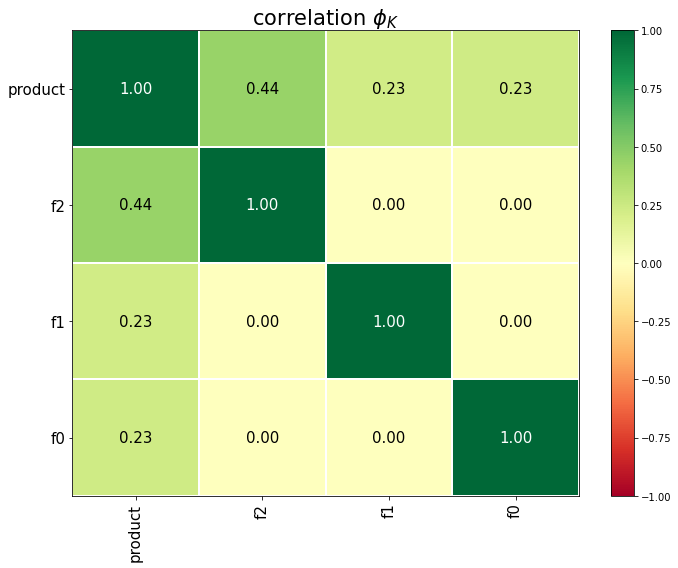

In [43]:
# вычисление коэффициентов корреляции phi для датафрейма geo_data_2
phik_overview = geo_data_2.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

Из анализа матрицы корреляции датасета geo_data_2 видно, что мультиколлинеарности нет.

При этом целевой признак product слабо коррелирует (0,44) с признаком f2.

Остальные признаки коррелируют между собой слабо.

### Вывод по загрузке и подготовка данных

**Исходные данные**  

Данные геологоразведки трёх регионов находятся в файлах: 
    
- `/datasets/geo_data_0.csv`

- `/datasets/geo_data_1.csv`
    
- `/datasets/geo_data_2.csv`

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек 
- **product** — объём запасов в скважине (тыс. баррелей).

---

**Предобработка данных**

Данные в таблицах соответствуют описанию. В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов

На этапе предобработке данных проверили, что в данных:

- нет дубликатов
- нет пропусков
- типы столбцов указаны верно
- Название столбцов корректны

Столбец `id` сделали индексом

---

**Исследовательский анализ**

На этапе исследовательского анализа данных были обнаружены выбросы. Поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, Было принято решения об удалении выбросов.

Для отсеивания выбросов использовали метод Межквартильного размаха

---

**Корреляционный анализ**

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа использовали матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков.

- Из анализа матрицы корреляции датасета `geo_data_0` видно, что мультиколлинеарности нет.

    При этом целевой признак product слабо коррелирует (0,48) с признаком f2.

    Также прослеживается сильная корреляция между признаками f1 и f0.

    Остальные признаки коррелируют между собой слабо.


- Из анализа матрицы корреляции датасета `geo_data_1` видно, что мультиколлинеарность прослеживается между целевым признаком product и признаком f2 (коэффициент корреляции 0.98). Избавляться от нее на данном этапе не будем, так как это корреляция с целевым признаком.

    Также прослеживается средняя корреляция между целевым признаком (product) и признаком f0 (коэффициент корреляции 0.63)

    Остальные признаки коррелируют между собой слабо.

- Из анализа матрицы корреляции датасета `geo_data_2` видно, что мультиколлинеарности нет.

    При этом целевой признак product слабо коррелирует (0,44) с признаком f2.

    Остальные признаки коррелируют между собой слабо.

## Обучение и проверка модели

*Обучите и проверьте модель для каждого региона:*
- *2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.*
- *2.2. Обучите модель и сделайте предсказания на валидационной выборке.*
- *2.3. Сохраните предсказания и правильные ответы на валидационной выборке.*
- *2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.*
- *2.5. Проанализируйте результаты.*

In [44]:
def LinearRegression_model(df):
    # зададим целевой признак и подготовим данные
    X = df.drop(['product'], axis=1)
    y = df['product'] 
    
    # разбьём данные на обучающую и валидационную выборки в соотношении 75:25
    X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    # масштабируем количественные признаки
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    # инициируем модели линейной регрессии
    model = LinearRegression()
    # обучим модель
    model.fit(X_train, y_train)
    # сделаем прогнозы
    predicted_valid = model.predict(X_valid)
    
    # расчет метрики rmse
    rmse = (mean_squared_error(y_valid, predicted_valid))**0.5
    
    # расчет среднего запаса сырья
    predicted_valid_mean = predicted_valid.mean()
    
    y_valid = y_valid.reset_index(drop=True)
    predicted_valid = pd.Series(predicted_valid)
    
    return y_valid, predicted_valid, rmse, predicted_valid_mean

In [45]:
#Предскажем средний запас сырья и RMSE для каждого региона
y_valid_0, predicted_valid_0, rmse_0, predicted_valid_mean_0 = LinearRegression_model(geo_data_0)
y_valid_1, predicted_valid_1, rmse_1, predicted_valid_mean_1 = LinearRegression_model(geo_data_1)
y_valid_2, predicted_valid_2, rmse_2, predicted_valid_mean_2 = LinearRegression_model(geo_data_2)

In [46]:
print(f'\033[1mрегион geo_data_0\033[0m')
print('средний запас сырья для geo_data_0:', round(predicted_valid_mean_0, 2), '(тыс. баррелей)')
print('RMSE для geo_data_0:', round(rmse_0, 2))
print('*' * 125)

print(f'\033[1mрегион geo_data_1\033[0m')
print('средний запас сырья для geo_data_1:', round(predicted_valid_mean_1, 2), '(тыс. баррелей)')
print('RMSE для geo_data_1:', round(rmse_1, 2))
print('*' * 125)

print(f'\033[1mрегион geo_data_2\033[0m')
print('средний запас сырья для geo_data_2:', round(predicted_valid_mean_2, 2), '(тыс. баррелей)')
print('RMSE для geo_data_2:', round(rmse_2, 2))
print('*' * 125)

регион geo_data_0
средний запас сырья для geo_data_0: 92.35 (тыс. баррелей)
RMSE для geo_data_0: 37.82
*****************************************************************************************************************************
регион geo_data_1
средний запас сырья для geo_data_1: 68.96 (тыс. баррелей)
RMSE для geo_data_1: 0.89
*****************************************************************************************************************************
регион geo_data_2
средний запас сырья для geo_data_2: 94.95 (тыс. баррелей)
RMSE для geo_data_2: 40.13
*****************************************************************************************************************************


**Вывод**

На данном этапе обучили и проверили модель линейной регрессии для каждого региона:

- Самый большой средний запас сырья получился в регионе geo_data_2.
- Самая маленькая ошибка RMSE в регионе geo_data_1.

---

**регион geo_data_0**

- средний запас сырья для geo_data_0: 92.35 (тыс. баррелей)    
- RMSE для geo_data_0: 37.82
*****************************************************************************************************************************
**регион geo_data_1** 

- средний запас сырья для geo_data_1: 68.96 (тыс. баррелей)
- RMSE для geo_data_1: 0.89
*****************************************************************************************************************************
**регион geo_data_2**

- средний запас сырья для geo_data_2: 94.95 (тыс. баррелей)
- RMSE для geo_data_2: 40.13


## Подготовка к расчёту прибыли

*Подготовьтесь к расчёту прибыли:*
- *3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.*
- *3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.*
- *3.3. Напишите выводы по этапу подготовки расчёта прибыли.*

---

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Определение переменных

In [47]:
points = 500
best_points = 200
development_budget = 10 * 10**9

price_per_barrel = 450
income = 450000

loss_threshold = 2.5

### Расчет объема сырья

In [48]:
# Определим бюджет на разработку 1 скважины в регионе
print('Бюджет на разработку 1 скважины в регионе:', development_budget / best_points, 'руб.')

# Определим объём сырья для безубыточной разработки новой скважины (тыс. баррелей)
min_volume_materials = development_budget / best_points / income
print('Объём сырья для безубыточной разработки новой скважины', round(min_volume_materials, 2), '(тыс. баррелей)')

Бюджет на разработку 1 скважины в регионе: 50000000.0 руб.
Объём сырья для безубыточной разработки новой скважины 111.11 (тыс. баррелей)


**Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [49]:
print('Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_0:',\
     round(min_volume_materials - predicted_valid_mean_0, 2), '(тыс. баррелей)')

print('Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_1:',\
     round(min_volume_materials - predicted_valid_mean_1, 2), '(тыс. баррелей)')

print('Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_2:',\
     round(min_volume_materials - predicted_valid_mean_2, 2), '(тыс. баррелей)')

Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_0: 18.76 (тыс. баррелей)
Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_1: 42.15 (тыс. баррелей)
Отклонение среднего объема добычи сырья от точки безубыточности в регионе geo_data_2: 16.16 (тыс. баррелей)


### Вывод по подготовке к расчёту прибыли

На данном этапе работы определили:
- Бюджет на разработку 1 скважины в регионе: 50000000.0
- Объем сырья для безубыточной разработки новой скважины 111.11

Рассчитали отклонение среднего объема добычи сырья от точки безубыточности в каждом регионе:
- для региона geo_data_0: 18.76 (тыс. баррелей)
- для региона geo_data_1: 42.15 (тыс. баррелей)
- для региона geo_data_2: 16.16 (тыс. баррелей)  

Самое большое отклонение среднего объема добычи сырья от точки безубыточности получилось в регионе geo_data_1.

## Расчёт прибыли и рисков 

*Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:*
- *Выберите скважины с максимальными значениями предсказаний.*
- *Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.*
- *Рассчитайте прибыль для полученного объёма сырья.*

*Посчитайте риски и прибыль для каждого региона:*
- *Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.*
- *Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.*
- *Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор*.

In [50]:
#функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit_calculation(target, predicted):
    df = pd.concat([target, predicted], axis=1)
    df.columns = ['target', 'predicted']
    selected = df.sort_values(by = 'predicted', ascending = False)[:best_points] 
    return income * selected['target'].sum() - development_budget

In [51]:
print(f'Прибыль для полученного объёма сырья в регионе geo_data_0: \
{round(profit_calculation(y_valid_0, predicted_valid_0), 2):,}'.replace(',', ' '), 'руб.')

print(f'Прибыль для полученного объёма сырья в регионе geo_data_1: \
{round(profit_calculation(y_valid_1, predicted_valid_1), 2):,}'.replace(',', ' '), 'руб.')

print(f'Прибыль для полученного объёма сырья в регионе geo_data_1: \
{round(profit_calculation(y_valid_2, predicted_valid_2), 2):,}'.replace(',', ' '), 'руб.')

Прибыль для полученного объёма сырья в регионе geo_data_0: 3 252 359 903.11 руб.
Прибыль для полученного объёма сырья в регионе geo_data_1: 2 415 086 696.68 руб.
Прибыль для полученного объёма сырья в регионе geo_data_1: 2 385 314 465.93 руб.


Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [52]:
def bootstrap (target, predicted):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=points, replace=True, random_state=state)
        pred_subsumple = predicted[target_subsample.index]
        
        values.append(profit_calculation(target_subsample, pred_subsumple))
        
    values = pd.Series(values)
    values_mean = values.mean()
    lower = round(values.quantile(0.025), 2)
    upper = round(values.quantile(0.975), 2)
    
    #95%-й доверительный интервал
    confidence_interval = (lower, upper)
    # риск убытков
    risk_of_losses = len(values[values < 0]) / len(values) * 100
    
    print(f'Средняя прибыль:, {round(values_mean,2):,}'.replace(',', ' '),'руб.')
    print(f'95% доверительный интервал:{confidence_interval}')
    print('Процент риска:', round(risk_of_losses,2), '%')
    

In [53]:
print('Для региона geo_data_0:')
bootstrap(y_valid_0, predicted_valid_0)
print('*' * 125)

print('Для региона geo_data_1:')
bootstrap(y_valid_1, predicted_valid_1)
print('*' * 125)

print('Для региона geo_data_2:')
bootstrap(y_valid_2, predicted_valid_2)
print('*' * 125)

Для региона geo_data_0:
Средняя прибыль:  393 086 331.86 руб.
95% доверительный интервал:(-146392843.7, 898526291.75)
Процент риска: 6.6 %
*****************************************************************************************************************************
Для региона geo_data_1:
Средняя прибыль:  455 772 670.52 руб.
95% доверительный интервал:(55766165.53, 851765420.27)
Процент риска: 1.5 %
*****************************************************************************************************************************
Для региона geo_data_2:
Средняя прибыль:  375 536 745.74 руб.
95% доверительный интервал:(-136944412.12, 857034891.82)
Процент риска: 7.7 %
*****************************************************************************************************************************


**Вывод**

Для нахождения прибыли применили технику Bootstrap с 1000 выборок.
Для каждого региона была рассчитана средняя прибыль, 95%-й доверительный интервал и вероятность убытков.

Для региона geo_data_0:
- Средняя прибыль:  393 086 331.86 руб.
- 95% доверительный интервал:(-146392843.7, 898526291.75)
- Процент риска: 6.6 %
*****************************************************************************************************************************
Для региона geo_data_1:
- Средняя прибыль:  455 772 670.52 руб.
- 95% доверительный интервал:(55766165.53, 851765420.27)
- Процент риска: 1.5 %
*****************************************************************************************************************************
Для региона geo_data_2:
- Средняя прибыль:  375 536 745.74 руб.
- 95% доверительный интервал:(-136944412.12, 857034891.82)
- Процент риска: 7.7 %
    
Следовательно для разработки скважин можно порекомендовать регион geo_data_1, с наименьшим процентом риска (1.5%) и наибольшей средней прибылью (455 772 670.52 руб.). 

Отметим, что в регионах geo_data_0 и geo_data_2 вероятность убытков составляет 6.6% и 7.7% соответственно, что превышает максимальную допустимую вероятность (2.5%).

## Общий вывод

**Выбор локации для скважины**


Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель исследования**

Определить, где бурить новую скважину.

---

**Задачи исследования**

Построить модель для определения региона, где добыча принесёт наибольшую прибыль.

---

**Исходные данные**  

Данные геологоразведки трёх регионов находятся в файлах: 
    
- `/datasets/geo_data_0.csv`

- `/datasets/geo_data_1.csv`
    
- `/datasets/geo_data_2.csv`

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек 
- **product** — объём запасов в скважине (тыс. баррелей).

---
**Предобработка данных**

На этапе предобработки данных убедились, что данные в таблицах соответствуют описанию. В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов

На этапе предобработке данных проверили, что в данных:

- нет дубликатов
- нет пропусков
- типы столбцов указаны верно
- название столбцов корректны

Столбец id сделали индексом

---

**Исследовательский анализ данных**

На этапе исследовательского анализа данных были обнаружены выбросы. Поскольку данные засекречены и мы не можем однозначно сделать вывод об их реалистичности, Было принято решение об удалении выбросов.

Для отсеивания выбросов использовали метод Межквартильного размаха

---

**Корреляционный анализ**

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа использовали матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков.

- Из анализа матрицы корреляции датасета `geo_data_0` видно, что мультиколлинеарности нет.

    При этом целевой признак product слабо коррелирует (0,48) с признаком f2.

    Также прослеживается сильная корреляция между признаками f1 и f0.

    Остальные признаки коррелируют между собой слабо.


- Из анализа матрицы корреляции датасета `geo_data_1` видно, что мультиколлинеарность прослеживается между целевым признаком product и признаком f2 (коэффициент корреляции 0.98). Избавляться от нее на данном этапе не будем, так как это корреляция с целевым признаком.

    Также прослеживается средняя корреляция между целевым признаком (product) и признаком f0 (коэффициент корреляции 0.63)

    Остальные признаки коррелируют между собой слабо.
    

- Из анализа матрицы корреляции датасета `geo_data_2` видно, что мультиколлинеарности нет.

    При этом целевой признак product слабо коррелирует (0,44) с признаком f2.

    Остальные признаки коррелируют между собой слабо.
    
---

**Обучение и проверка модели**

На данном этапе обучили и проверили модель линейной регрессии для каждого региона:

- Самый большой средний запас сырья получился в регионе geo_data_2.
- Самая маленькая ошибка RMSE в регионе geo_data_1.

**регион geo_data_0**

- средний запас сырья для geo_data_0: 92.35 (тыс. баррелей)    
- RMSE для geo_data_0: 37.82
*****************************************************************************************************************************
**регион geo_data_1** 

- средний запас сырья для geo_data_1: 68.96 (тыс. баррелей)
- RMSE для geo_data_1: 0.89
*****************************************************************************************************************************
**регион geo_data_2**

- средний запас сырья для geo_data_2: 94.95 (тыс. баррелей)
- RMSE для geo_data_2: 40.13

---

**Подготовка к расчёту прибыли**

На данном этапе работы определили:
- Бюджет на разработку 1 скважины в регионе: 50000000 руб.
- Объем сырья для безубыточной разработки новой скважины 111.11 (тыс. баррелей)

Рассчитали отклонение среднего объема добычи сырья от точки безубыточности в каждом регионе:
- для региона `geo_data_0`: 18.76 (тыс. баррелей)
- для региона `geo_data_1`: 42.15 (тыс. баррелей)
- для региона `geo_data_2`: 16.16 (тыс. баррелей)  

Самое большое отклонение среднего объема добычи сырья от точки безубыточности получилось в регионе geo_data_1.

---

**Расчёт прибыли и рисков**

Для нахождения прибыли применили технику Bootstrap с 1000 выборок. Для каждого региона была рассчитана средняя прибыль, 95%-й доверительный интервал и вероятность убытков.

Для региона `geo_data_0`: 
- Средняя прибыль: 393 086 331.86 руб. 
- 95% доверительный интервал:(-146392843.7, 898526291.75) 
- Процент риска: 6.6 %

Для региона `geo_data_1`: 
- Средняя прибыль: 455 772 670.52 руб. 
- 95% доверительный интервал:(55766165.53, 851765420.27) 
- Процент риска: 1.5 %

Для региона `geo_data_2`: 
- Средняя прибыль: 375 536 745.74 руб. 
- 95% доверительный интервал:(-136944412.12, 857034891.82) 
- Процент риска: 7.7 %

`Следовательно для разработки скважин можно порекомендовать регион geo_data_1, с наименьшим процентом риска (1.5%) и наибольшей средней прибылью (455 772 670.52 руб.).`

Отметим, что в регионах geo_data_0 и geo_data_2 вероятность убытков составляет 6.6% и 7.7% соответственно, что превышает максимальную допустимую вероятность (2.5%).